In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

class CartpoleNetLite(nn.Module):
  def __init__(self):
    super(CartpoleNetLite, self).__init__()
    self.conv1 = nn.Conv3d(1, 8, 3, padding=1) 
    self.conv2 = nn.Conv3d(8, 16, 3, padding=1)
    self.conv3 = nn.Conv3d(16, 32, 3, padding=1)
    self.fc1 = nn.Linear(16 * 16 * 32, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 4)

  def forward(self, x):
    x = F.max_pool3d(F.relu(self.conv1(x)), (1,2,2)) # 64x64
    x = F.max_pool3d(F.relu(self.conv2(x)), (1,2,2)) # 32x32
    x = F.max_pool3d(F.relu(self.conv3(x)), (1,2,2)) # 16x16
    x = torch.sum(x, axis=2)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

  def num_flat_features(self, x):
    size = x.size()[1:]  # all dimensions except the batch dimension
    num_features = 1
    for s in size:
        num_features *= s
    return num_features

In [0]:
def create_batch(dataset, batch_size=32, epoch=0, index=0):
  '''
  retrieves a batch of training data to work on. given the specified
  starting epoch and starting index. 
  '''
  index %= 50
  assert(epoch < 220 and epoch >= 0)
  assert(index >= 3 and index <= 48)

  train_x = dataset[epoch * 50 + index][0].unsqueeze(0) # gets first training point 
  train_y = torch.tensor(dataset[epoch * 50 + index][1][-2, :]).unsqueeze(0) # gets second to last delta state 

  # epoch * 50 + index


  for i in range(batch_size - 1):
    index += 1
    if (index > 48):
      # resetting indices so we are in the right area
      epoch += 1
      index = 3 
    if epoch >= 218:
      epoch = 0
    x = dataset[epoch * 50 + index][0].unsqueeze(0)
    y = torch.tensor(dataset[epoch * 50 + index][1][-2, :]).unsqueeze(0)
    train_x = torch.cat((train_x, x), axis=0)
    train_y = torch.cat((train_y, y), axis=0)

  return (train_x.double(), train_y, epoch, index)

In [0]:
!unzip image_dataset.zip

In [0]:
from dataloader import CartpoleDataset 

path = './image_dataset/'
dataset = CartpoleDataset('data.csv', path, 5, H=128, W=128)


In [0]:
net = CartpoleNetLite().float().to("cuda")
criterion = nn.MSELoss()

JHist = []

optimizer = optim.Adam(net.parameters(), lr=0.01)

In [0]:
torch.autograd.set_detect_anomaly(True)

# 0.05, 0.01, 0.005, 0.0005
for i in range(1000):
  train_x, train_y, epoch, index = create_batch(dataset, 128, epoch, index)
  train_x = train_x.float().to("cuda")
  train_y = train_y.float().to("cuda")

  optimizer.zero_grad()
  y_pred = net(train_x)
  loss = criterion(y_pred, train_y)
  loss.backward()
  optimizer.step()

  epoch_loss = loss.item()
  JHist.append(epoch_loss)
  print(i, epoch_loss)


In [0]:
import matplotlib.pyplot as plt
print(JHist)
plt.plot(JHist[230:]) # before 230 was just overfitting on one batch
plt.xlabel("epoch")
plt.ylabel("mean-squared error")
plt.show()
plt.savefig("learning_curve.png")


In [0]:
from google.colab import files
PATH = './CartpoleNet3.pth'
torch.save(net.state_dict(), PATH)
files.download('./CartpoleNet3.pth')
# files.download('./learning_curve.png')


In [0]:
JHist_avg = []
ii = 0
sum = 0
for J in JHist:
  if ii % 100 == 99:
    JHist_avg.append(sum / 100)
    sum = 0
  else:
    sum += J
  ii += 1

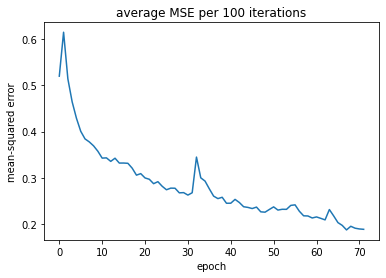

In [182]:
plt.clf()
plt.xlabel("epoch")
plt.ylabel("mean-squared error")
plt.title("average MSE per 100 iterations")
plt.plot(JHist_avg[2:])
plt.show()

In [0]:
index = 3